# Импортируем библиотеки

In [245]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,auc,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import catboost as cb
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.inspection import permutation_importance

## Задаем стили для графиков

In [246]:
params = {'figure.figsize' : (12,8),
         'font.size' : 12,
         'axes.titlesize' : 20,
         'axes.linewidth' : 2}

plt.rcParams.update(params)

bbox = {'boxstyle' : 'round',
        'pad' : 0.5,
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1,
        'alpha' : 1}

color = ['#E36149', '#49AF72']

plt.style.use('fivethirtyeight')

1) В данных присутствует 25 дат
2) В данных присутствуют 4817 id клиентов
3) Всего 436 клиентов приобрели себе машинное место в псоледущие 3 месяца
4) col1454 уникальный id их уникальнйх 4817 - его лучше удалить
5) Мы удалили столбцы в котрых больше 45% пропусков

# Импорт данных

In [247]:
df=pd.read_csv(r'C:\Users\Pasha\Desktop\train_dataset_Самолет.csv',low_memory=False) #,low_memory=False
df.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


In [4]:
# Смторим размерсноть датасета
df.shape

(14456, 2666)

In [284]:
# Смотрим типы данных столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB


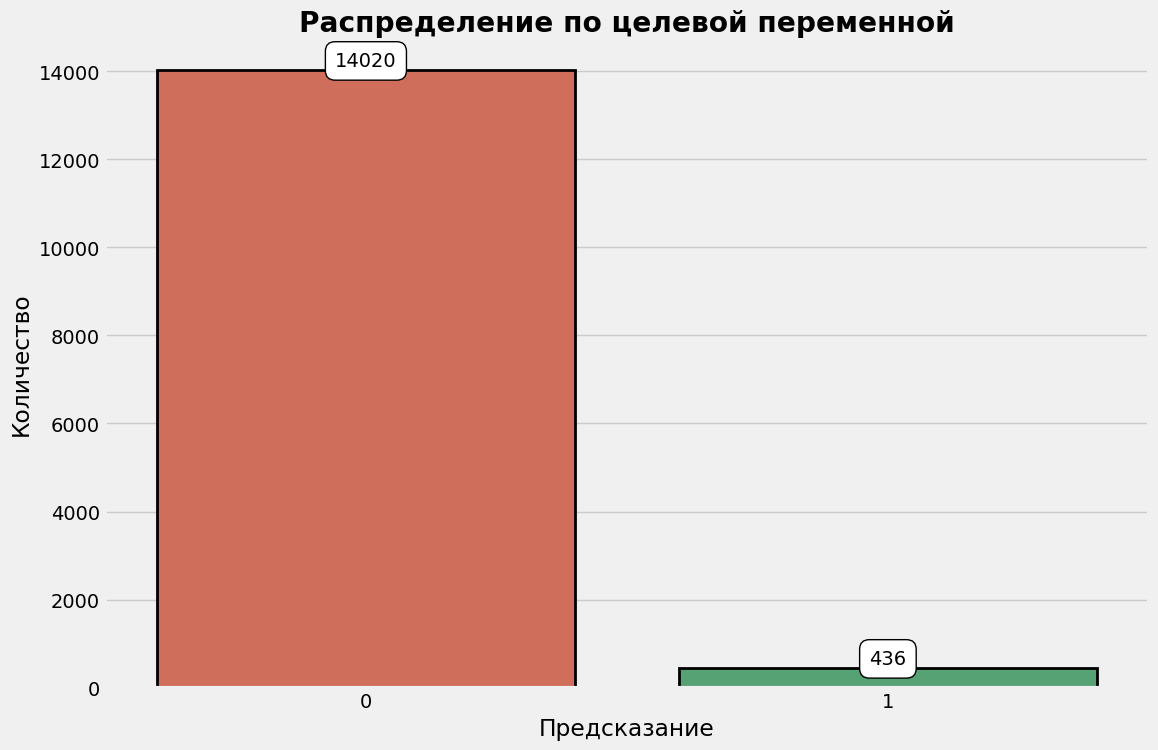

In [5]:
p1 = sns.countplot(data =df,
              x = 'target',
              linewidth = 2,
              edgecolor = 'black',
              palette = color)

plt.title('Распределение по целевой переменной', fontweight = 'bold')
plt.xlabel('Предсказание')
plt.ylabel('Количество')
p1.bar_label(p1.containers[0], bbox = bbox)

plt.show()

## Визуализируем пропуски

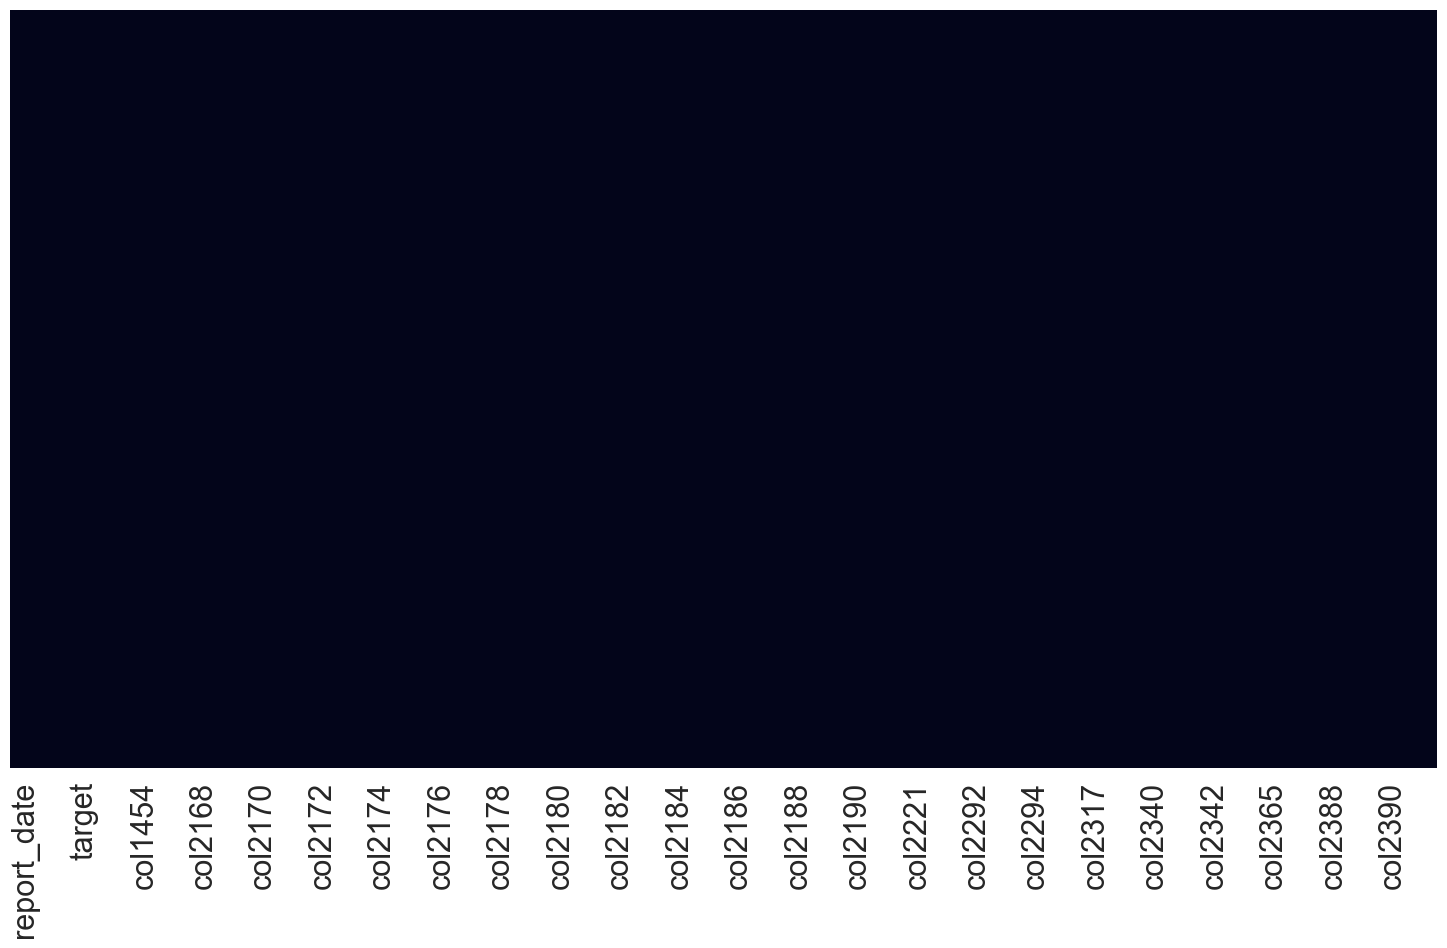

In [112]:
plt.figure(figsize=(15,10))
sns.heatmap(df.isna(),yticklabels=False,cbar=False)
plt.tight_layout()
plt.show()

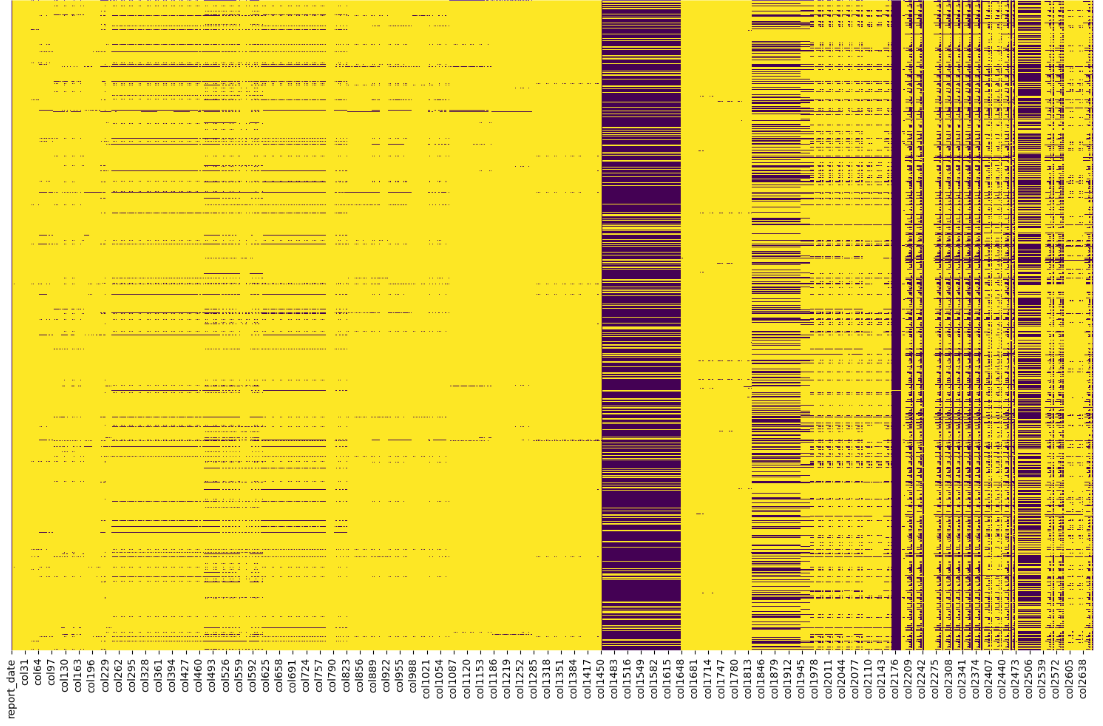

In [123]:
df.head()

,report_date,client_id,target,col1453,col1454,col2167,col2168,col2169,col2170,col2171,...,col2340,col2341,col2342,col2364,col2365,col2366,col2388,col2389,col2390,col2663
0,2022-11-01,1,0,0,00f3d719-a6ec-4960-ba01-8372eb705443,0.0,0.0,0.0,0.0,0.0,...,6801884.32,6801884.32,6801884.320,1.0,1.0,1.0,37.88,37.88,37.880,0.256261
1,2022-11-01,5,0,1,01febac0-b083-494e-8589-f98400074b94,0.0,0.0,0.0,0.0,0.0,...,7938208.75,318565.86,4128387.305,1.0,1.0,1.0,38.75,3.34,21.045,0.256261
2,2022-05-01,6,0,0,0278175e-c0bb-4e1e-bfe5-20db6811d3e2,0.0,0.0,0.0,0.0,0.0,...,7002418.50,7002418.50,7002418.500,1.0,1.0,1.0,36.75,36.75,36.750,0.256261
3,2022-09-01,7,0,0,0364571d-5325-ed11-b823-005056b825cd,1.0,1.0,1.0,1.0,1.0,...,8280003.76,8280003.76,8280003.760,1.0,1.0,1.0,35.56,35.56,35.560,0.258682
4,2022-08-01,8,0,0,065957a6-9b2a-435a-b561-024e9e8d9ad7,0.0,0.0,0.0,0.0,0.0,...,9426889.64,9426889.64,9426889.640,2.0,2.0,2.0,54.52,54.52,54.520,0.254164


## Удалям столбцы в которых прощено меньше или равно 1% данных

In [248]:
thresh = int(df.shape[0] * 0.01)

columns = df.columns[df.isna().sum() <= thresh]

df = df[columns]
df.dropna(inplace=True)

## Визуализируем пропуски

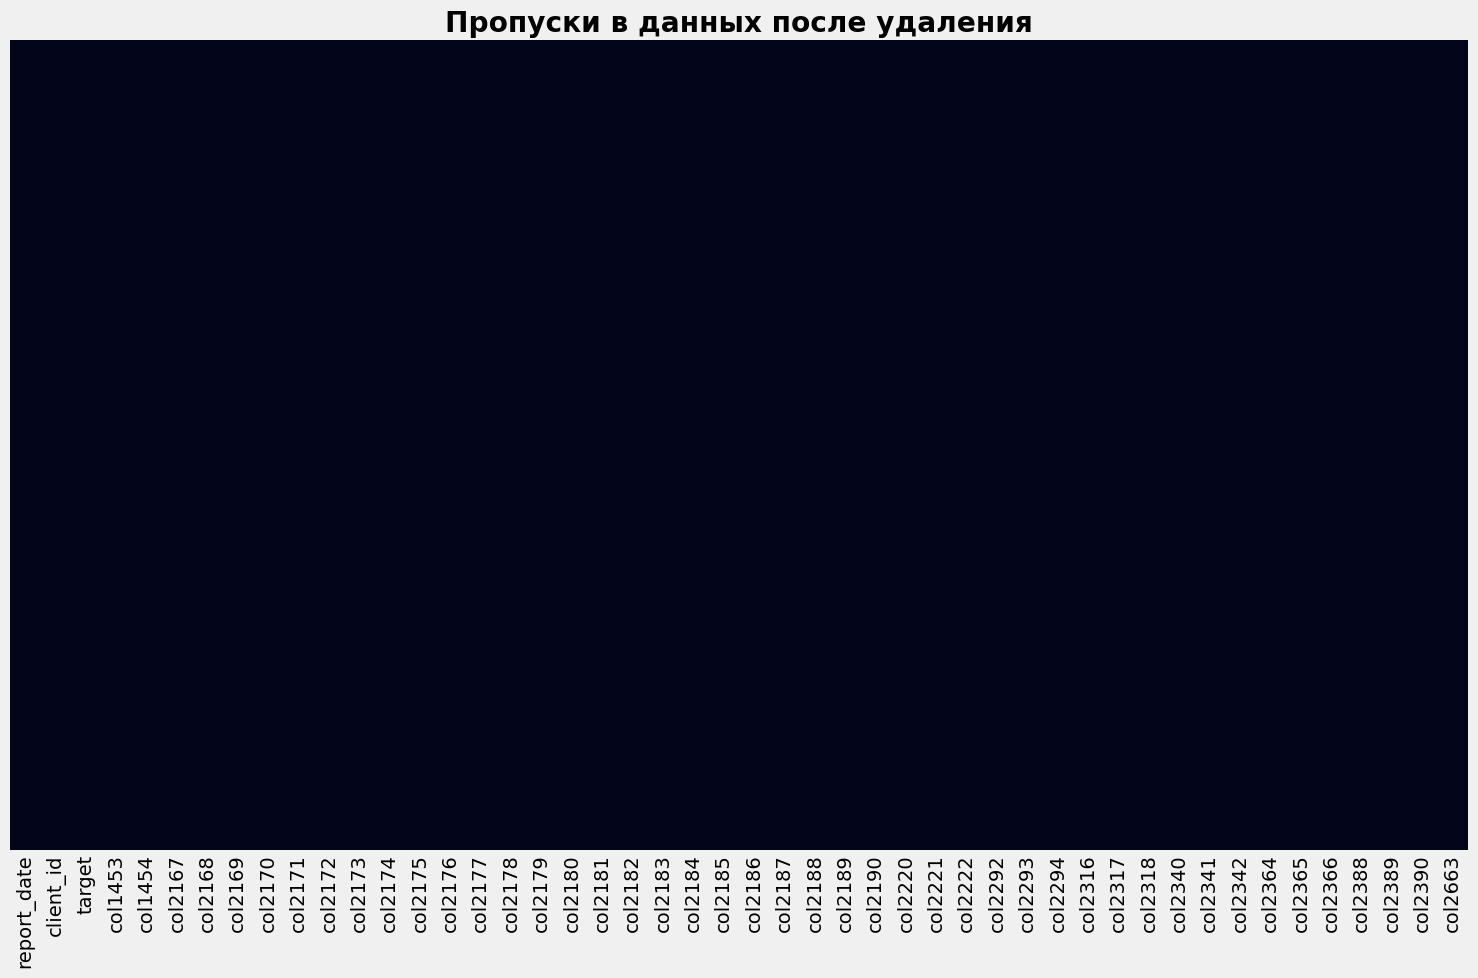

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(df.isna(),yticklabels=False,cbar=False)
plt.title('Пропуски в данных после удаления', fontweight = 'bold')
plt.tight_layout()
plt.show()

In [208]:
df.head()

,report_date,client_id,target,col1453,col1454,col2167,col2168,col2169,col2170,col2171,...,col2340,col2341,col2342,col2364,col2365,col2366,col2388,col2389,col2390,col2663
0,2022-11-01,1,0,0,00f3d719-a6ec-4960-ba01-8372eb705443,0.0,0.0,0.0,0.0,0.0,...,6801884.32,6801884.32,6801884.320,1.0,1.0,1.0,37.88,37.88,37.880,0.256261
1,2022-11-01,5,0,1,01febac0-b083-494e-8589-f98400074b94,0.0,0.0,0.0,0.0,0.0,...,7938208.75,318565.86,4128387.305,1.0,1.0,1.0,38.75,3.34,21.045,0.256261
2,2022-05-01,6,0,0,0278175e-c0bb-4e1e-bfe5-20db6811d3e2,0.0,0.0,0.0,0.0,0.0,...,7002418.50,7002418.50,7002418.500,1.0,1.0,1.0,36.75,36.75,36.750,0.256261
3,2022-09-01,7,0,0,0364571d-5325-ed11-b823-005056b825cd,1.0,1.0,1.0,1.0,1.0,...,8280003.76,8280003.76,8280003.760,1.0,1.0,1.0,35.56,35.56,35.560,0.258682
4,2022-08-01,8,0,0,065957a6-9b2a-435a-b561-024e9e8d9ad7,0.0,0.0,0.0,0.0,0.0,...,9426889.64,9426889.64,9426889.640,2.0,2.0,2.0,54.52,54.52,54.520,0.254164


## Предобработка данных

In [251]:
# Фунцкия для отображения выбросов в данных через boxplot
def plot_boxplots(dataframe):
    num_columns = dataframe.select_dtypes(include=['number']).columns 
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2  # Определение количества строк в сетке подграфиков

    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(40, 60))
    

    for i, column in enumerate(num_columns):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        sns.boxplot(x=dataframe[column], ax=ax)
        ax.set_title(f"Boxplot of {column}",fontsize=30,fontweight='bold')
        ax.set_xlabel(column)
        ax.tick_params(labelsize=20)
        

    plt.tight_layout()
    plt.show()

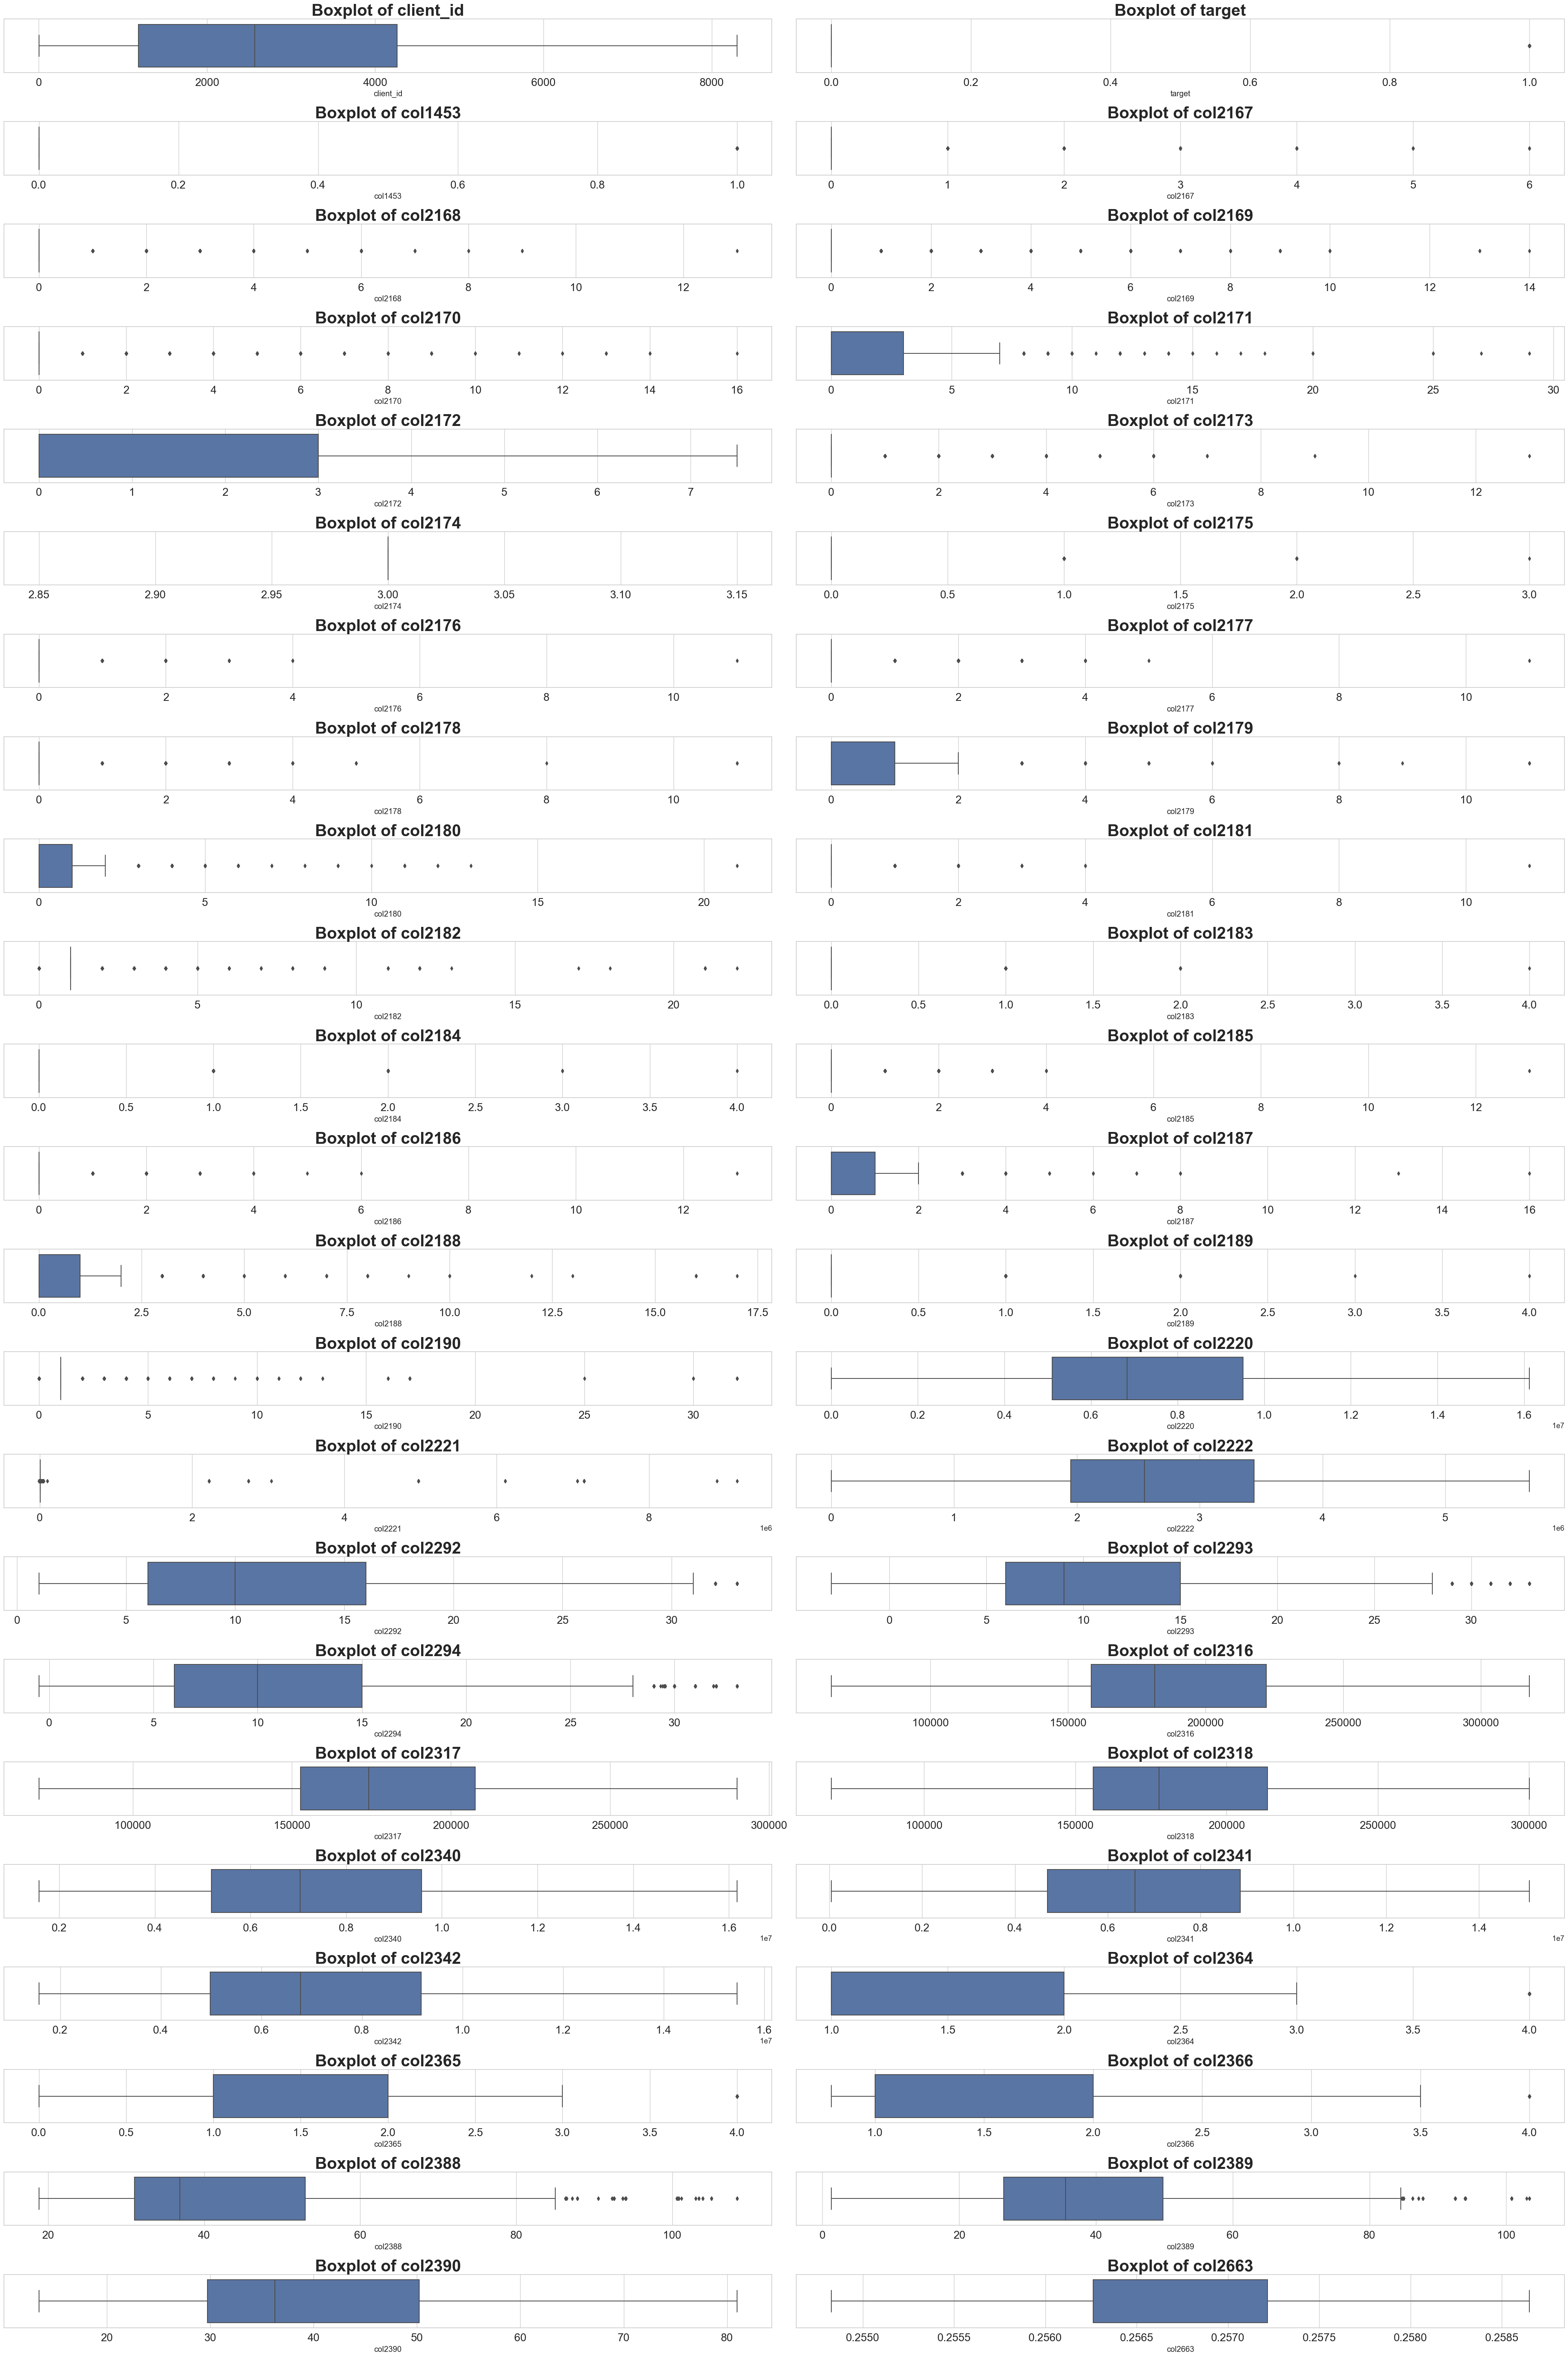

In [272]:
plot_boxplots(df) 

### Выделяем столбцы в котрых прсутствуют выбросы и заменеям выбросы на пограничные значения за счет межквантильного размаха

In [249]:
# Фунцкия для заменя выбросов на пограницчные значения
def remove_outliers(df, columns, k=1.5):
    """
Функция для удаления выбросов из указанных столбцов в DataFrame.

    Параметры:
    df (pandas.DataFrame): исходный DataFrame
    колонки (список): список столбцов, из которых нужно удалить выбросы
    k (float): коэффициент для расчета границ диапазона
    """
    for column in columns:
        # Рассчитываем первый и третий квартили
        q1 = df[column].quantile(0.25) # Находим 25% наименьших значений
        q3 = df[column].quantile(0.75) # Находим 25% наибольших значений

        # Рассчитываем межквартильный размах (разницу между наибольшими и наименьшими значениями)
        iqr = q3 - q1

        # Заменяем значения вне диапазона [q1 - k * iqr, q3 + k * iqr] на граничные значения
        # clip - используется для обрезки значений 
        # lower: минимальное значение для обрезки. Если значение элемента меньше lower, оно заменяется на lower.
        # upper: максимальное значение для обрезки. Если значение элемента больше upper, оно заменяется на upper.
        df[column] = df[column].clip(lower=q1 - k * iqr, upper=q3 + k * iqr)

    return df

In [250]:
remove_outliers(df,['col2663','col2390','col2342','col2341',
                    'col2340','col2317','col2222','col2220',
                   'col2172','col2172' ,'col2174','col2316','col2318'],k=1.5)

,report_date,client_id,target,col1453,col1454,col2167,col2168,col2169,col2170,col2171,...,col2340,col2341,col2342,col2364,col2365,col2366,col2388,col2389,col2390,col2663
0,2022-11-01,1,0,0,00f3d719-a6ec-4960-ba01-8372eb705443,0.0,0.0,0.0,0.0,0.0,...,6801884.32,6.801884e+06,6.801884e+06,1.0,1.0,1.0,37.88,37.88,37.880,0.256261
1,2022-11-01,5,0,1,01febac0-b083-494e-8589-f98400074b94,0.0,0.0,0.0,0.0,0.0,...,7938208.75,3.185659e+05,4.128387e+06,1.0,1.0,1.0,38.75,3.34,21.045,0.256261
2,2022-05-01,6,0,0,0278175e-c0bb-4e1e-bfe5-20db6811d3e2,0.0,0.0,0.0,0.0,0.0,...,7002418.50,7.002418e+06,7.002418e+06,1.0,1.0,1.0,36.75,36.75,36.750,0.256261
3,2022-09-01,7,0,0,0364571d-5325-ed11-b823-005056b825cd,1.0,1.0,1.0,1.0,1.0,...,8280003.76,8.280004e+06,8.280004e+06,1.0,1.0,1.0,35.56,35.56,35.560,0.258651
4,2022-08-01,8,0,0,065957a6-9b2a-435a-b561-024e9e8d9ad7,0.0,0.0,0.0,0.0,0.0,...,9426889.64,9.426890e+06,9.426890e+06,2.0,2.0,2.0,54.52,54.52,54.520,0.254827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,2022-07-01,1241,0,0,fc4b5aa0-c4d6-4394-93db-57a1505e66c4,0.0,0.0,0.0,0.0,0.0,...,6601754.40,6.601754e+06,6.601754e+06,2.0,2.0,2.0,56.48,56.48,56.480,0.258651
14452,2022-09-01,1969,1,0,fcc827d8-b64b-4b59-b718-87f2a51d77a4,0.0,0.0,0.0,0.0,0.0,...,15267823.20,1.508627e+07,1.526782e+07,2.0,2.0,2.0,64.40,64.40,64.400,0.258651
14453,2022-02-01,7116,1,0,fd5f22f5-36f6-4dca-9896-8c9e90bbb702,0.0,0.0,6.0,6.0,6.0,...,11800540.80,1.042520e+07,1.111287e+07,3.0,2.0,2.5,57.27,55.68,56.475,0.258651
14454,2021-08-01,7117,0,0,fdf04fb7-5404-4a9c-ae5b-e1e893060631,0.0,0.0,0.0,0.0,2.0,...,6272336.70,6.272337e+06,6.272337e+06,1.0,1.0,1.0,34.95,34.95,34.950,0.256261


# Деление данных на тестовые и тренеровочные

In [205]:
# Столбцы котрые не имеют особой значисмоти для catboost
'''
['col2170', 'col2178', 'col2188', 'col2186', 'col2182', 'col2190',
       'col2187', 'col2177', 'col2173', 'col2181', 'col2169', 'col1453',
       'col2176', 'col2168', 'col2167', 'col2184', 'col2185', 'col2175',
       'col2189', 'col2183']
'''

''''
'col2366', 'col2179', 'col2188', 'col2170', 'col2187', 'col2178',
       'col2365', 'col2186', 'col2177', 'col2190', 'col2176', 'col2167',
       'col2169', 'col2168', 'col2173', 'col1453', 'col2182', 'col2185',
       'col2184', 'col2181', 'col2189', 'col2183', 'col2175'
''''
'col1453','col2167','col2183','col2189','col2175','col2184','col2177','col2173' -для леса


SyntaxError: unterminated string literal (detected at line 14) (760120060.py, line 14)

In [264]:
# X=df.drop(columns=['target','report_date','col1454','client_id'],axis=1) ,
                   #'col1453','col2167','col2183','col2189','col2175','col2184','col2177','col2173'
X=df.drop(columns=['target','report_date','col1454','client_id','col2183', 'col2181', 'col2176',
       'col2175', 'col2184', 'col2167', 'col2174', 'col2173', 'col2189',
       'col2168', 'col1453'],axis=1)
y=df.target

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,stratify=y)

# Случайный лес(Его будем использовать)

In [265]:
rf = RandomForestClassifier(n_estimators=1000,
       n_jobs=-1,random_state=76) #n_estimators=1000, max_depth=7,random_state=42
       
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

In [267]:
rf.score(X_test,y_test)

0.986130374479889

### Натюненные гипперпараметры

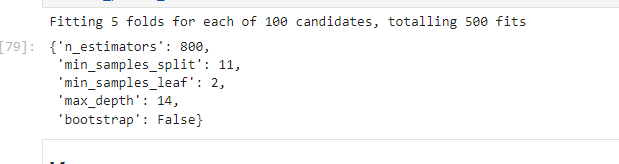

# Кроссвалидация 

In [268]:
from sklearn.model_selection import KFold, cross_val_score
# Создание объекта KFold с 2 фолдами
kf = KFold(n_splits=4,shuffle=True)
# Выполнение кросс-валидации
scores = cross_val_score(rf, X_train, y_train, cv=kf)

# Вывод результатов
print("Результаты кросс-валидации:", scores)
print("Среднее значение:", np.mean(scores))

Результаты кросс-валидации: [0.97911227 0.98009138 0.98759791 0.98237598]
Среднее значение: 0.9822943864229765


In [135]:
accuracy_score(y_test, y_hat)

0.984743411927878

In [269]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2098
           1       0.84      0.66      0.74        65

    accuracy                           0.99      2163
   macro avg       0.92      0.83      0.87      2163
weighted avg       0.99      0.99      0.99      2163



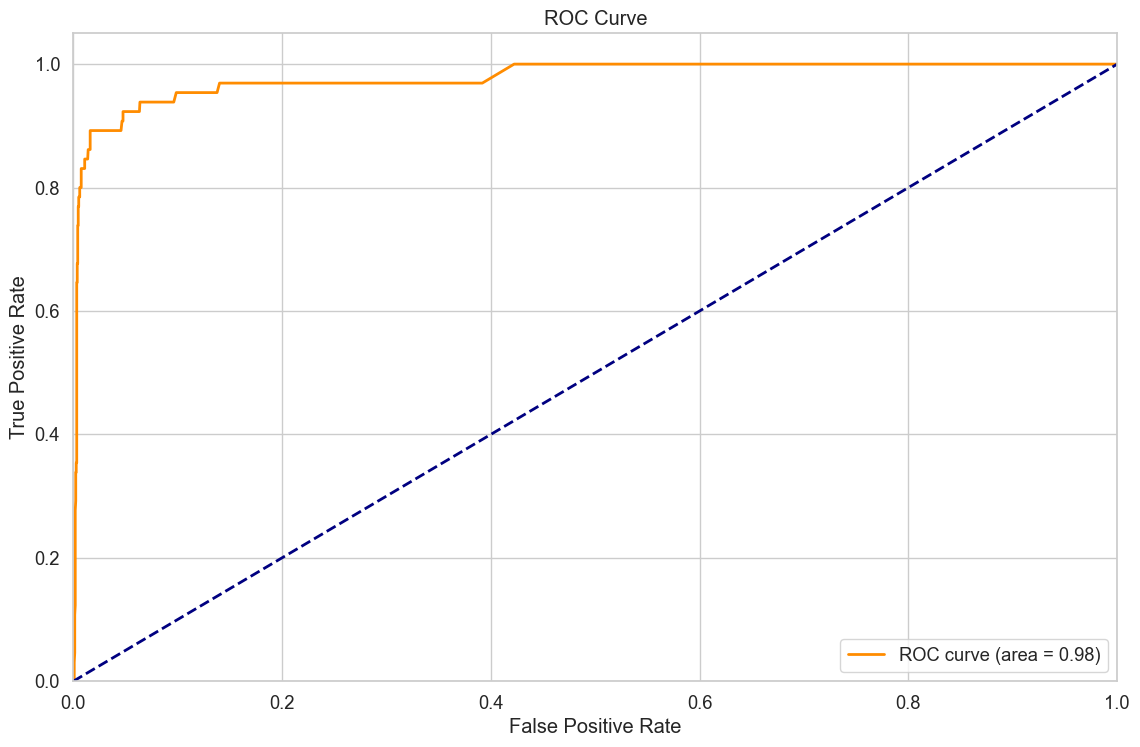

In [270]:
# y_scores = mmodel.predict_proba(X_test)[:, 1]
y_scores = rf.predict_proba(X_test)[:, 1]
#Вычислите ROC-кривую и AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

#Постройте ROC-кривую
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## AUC ROC

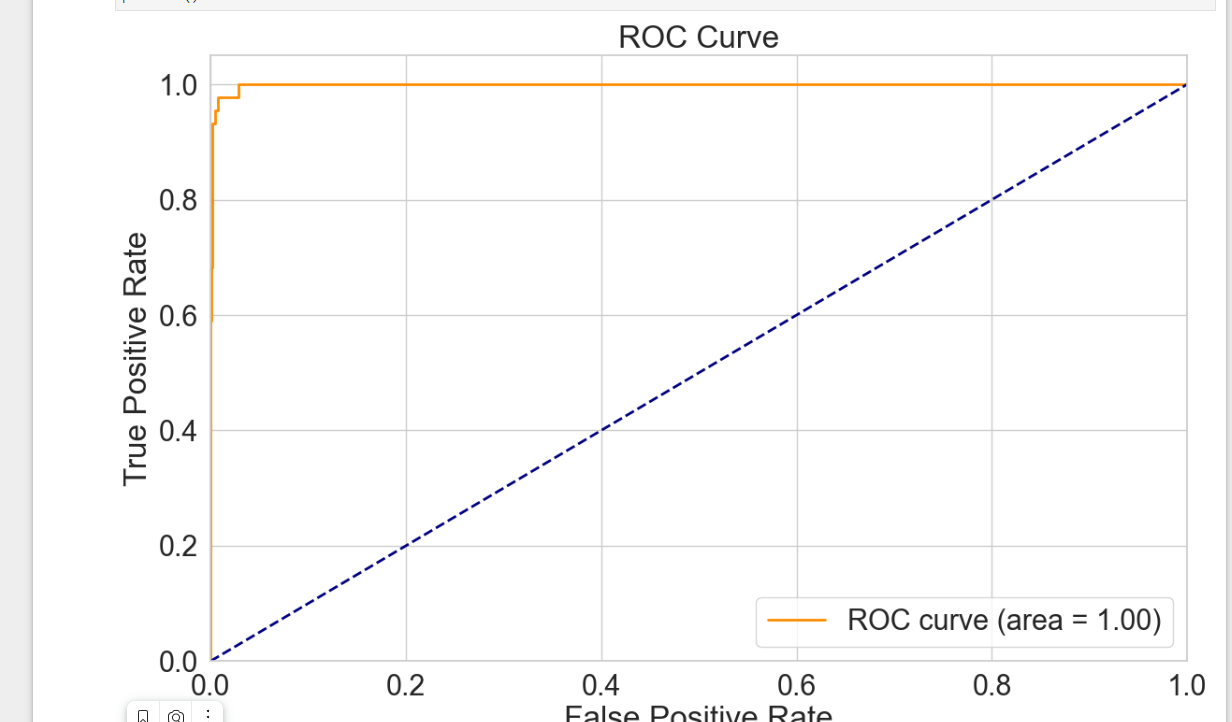

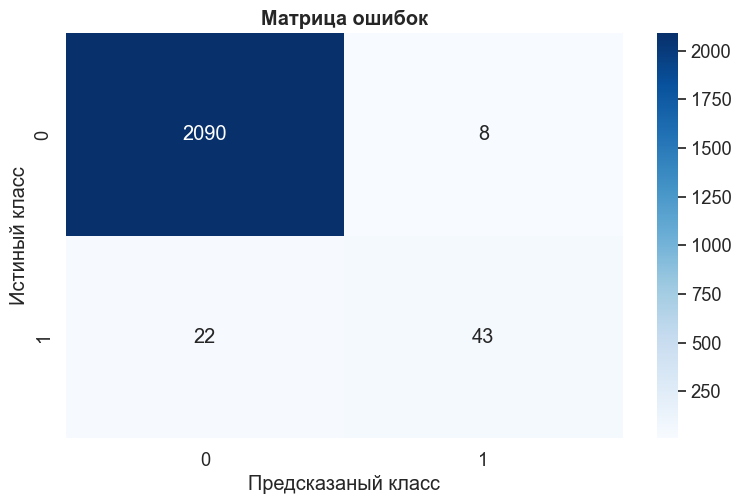

In [271]:
fig = plt.subplots(figsize = (8,5))

cm = confusion_matrix(y_test, y_hat)
sns.heatmap(cm, annot = True, fmt='d', cmap='Blues')

plt.title('Матрица ошибок', fontweight = 'bold')
plt.ylabel('Истиный класс')
plt.xlabel('Предсказаный класс')
plt.show()

# Важность переменных 

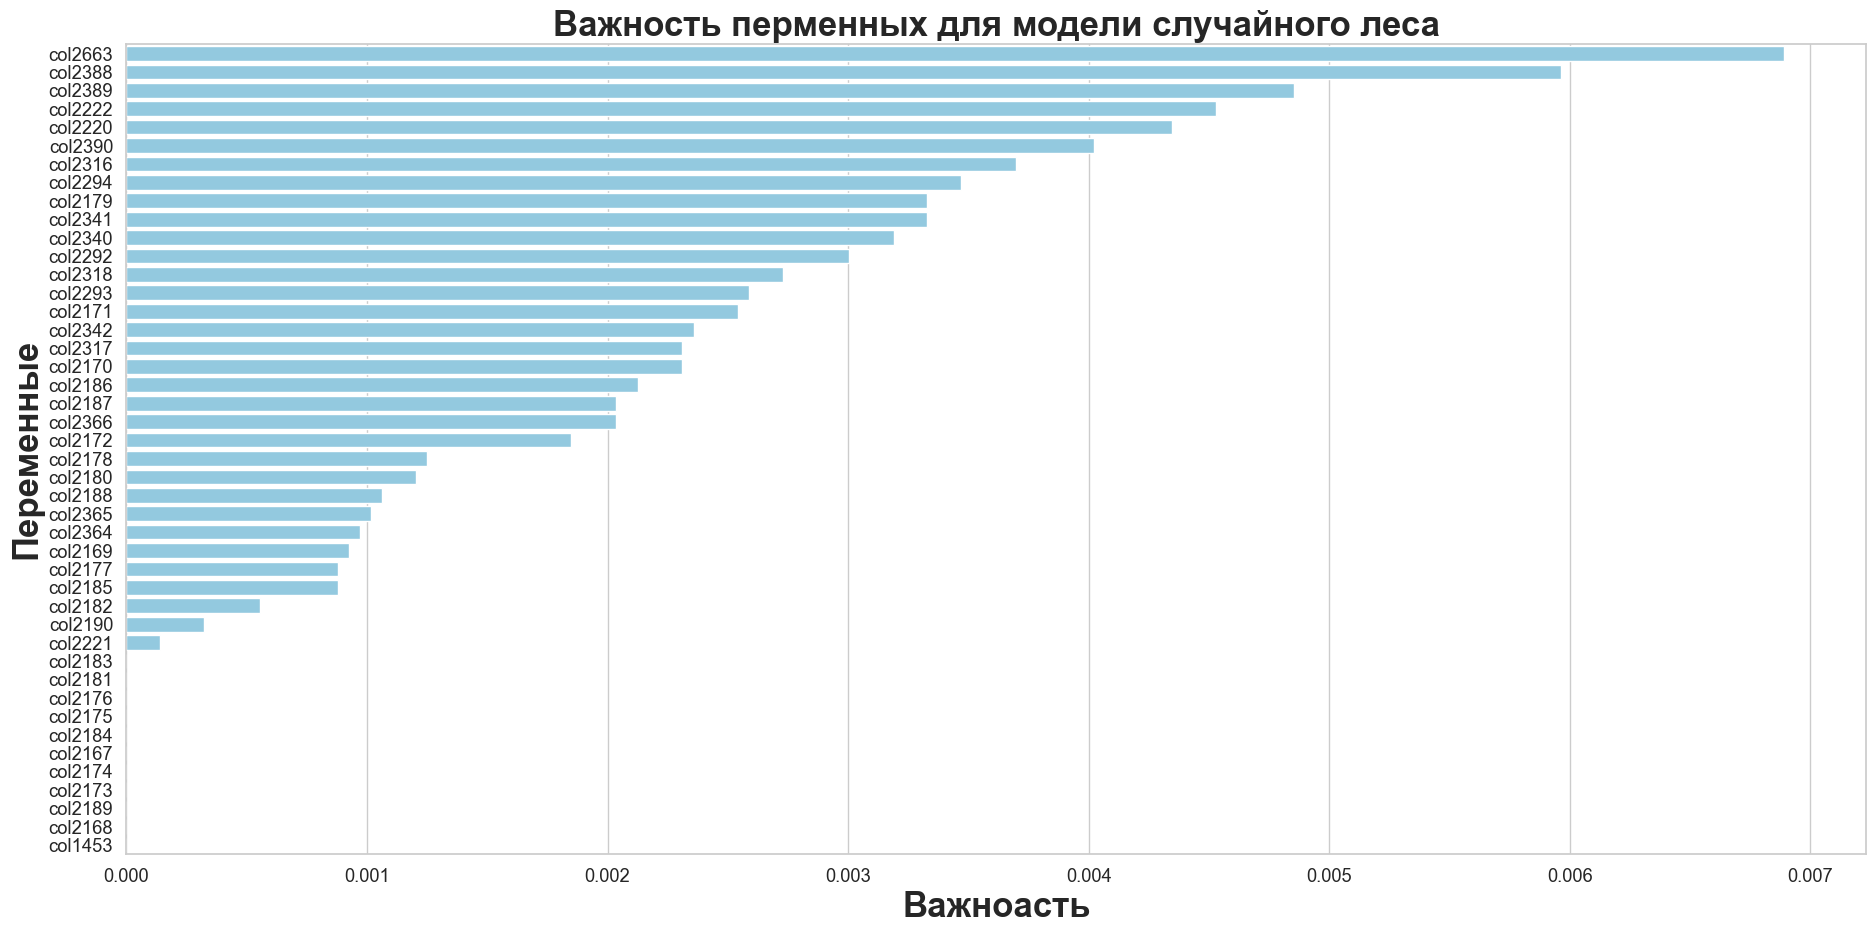

In [260]:
r = permutation_importance(rf,X_test,y_test,n_repeats=10)
perm=pd.DataFrame(columns=['Важность','STD_Важность'],index=[i for i in X_train.columns])
perm['Важность']=r.importances_mean
perm['STD_Важность']=r.importances_std

perm_importance_df = pd.DataFrame({'Feature': X_test.columns,
                                   'Importance': r.importances_mean})

# Отсортируйте признаки по важности
perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)
sns.set(font_scale = 10)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.2)

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(x='Importance', y='Feature', data=perm_importance_df,color='skyblue')
plt.title('Permutation Importance')
plt.xlabel('Важноасть', fontsize=25, weight = 'bold')
plt.ylabel('Переменные', fontsize=25, weight = 'bold')
plt.title('Важность перменных для модели случайного леса', fontsize=25, weight = 'bold')
plt.show()

In [261]:
perm_importance_df

,Feature,Importance
43,col2663,0.006889
40,col2388,0.005964
41,col2389,0.004854
27,col2222,0.004531
25,col2220,0.004346
42,col2390,0.004022
31,col2316,0.003699
30,col2294,0.003467
13,col2179,0.003329
35,col2341,0.003329


In [263]:
perm_importance_df.Feature.values

array(['col2663', 'col2388', 'col2389', 'col2222', 'col2220', 'col2390',
       'col2316', 'col2294', 'col2179', 'col2341', 'col2340', 'col2292',
       'col2318', 'col2293', 'col2171', 'col2342', 'col2317', 'col2170',
       'col2186', 'col2187', 'col2366', 'col2172', 'col2178', 'col2180',
       'col2188', 'col2365', 'col2364', 'col2169', 'col2177', 'col2185',
       'col2182', 'col2190', 'col2221', 'col2183', 'col2181', 'col2176',
       'col2175', 'col2184', 'col2167', 'col2174', 'col2173', 'col2189',
       'col2168', 'col1453'], dtype=object)

In [ ]:
['col2663', 'col2220', 'col2388', 'col2389', 'col2390', 'col2294',
       'col2222', 'col2293', 'col2318', 'col2341', 'col2317', 'col2170',
       'col2340', 'col2292', 'col2316', 'col2180', 'col2186', 'col2172',
       'col2342', 'col2179', 'col2174', 'col2221', 'col2365', 'col2366',
       'col2182', 'col2188', 'col2169', 'col2364', 'col2171', 'col2187',
       'col2185', 'col2178', 'col2181', 'col2176', 'col2168', 'col2190',
       'col2173']

## Catboost

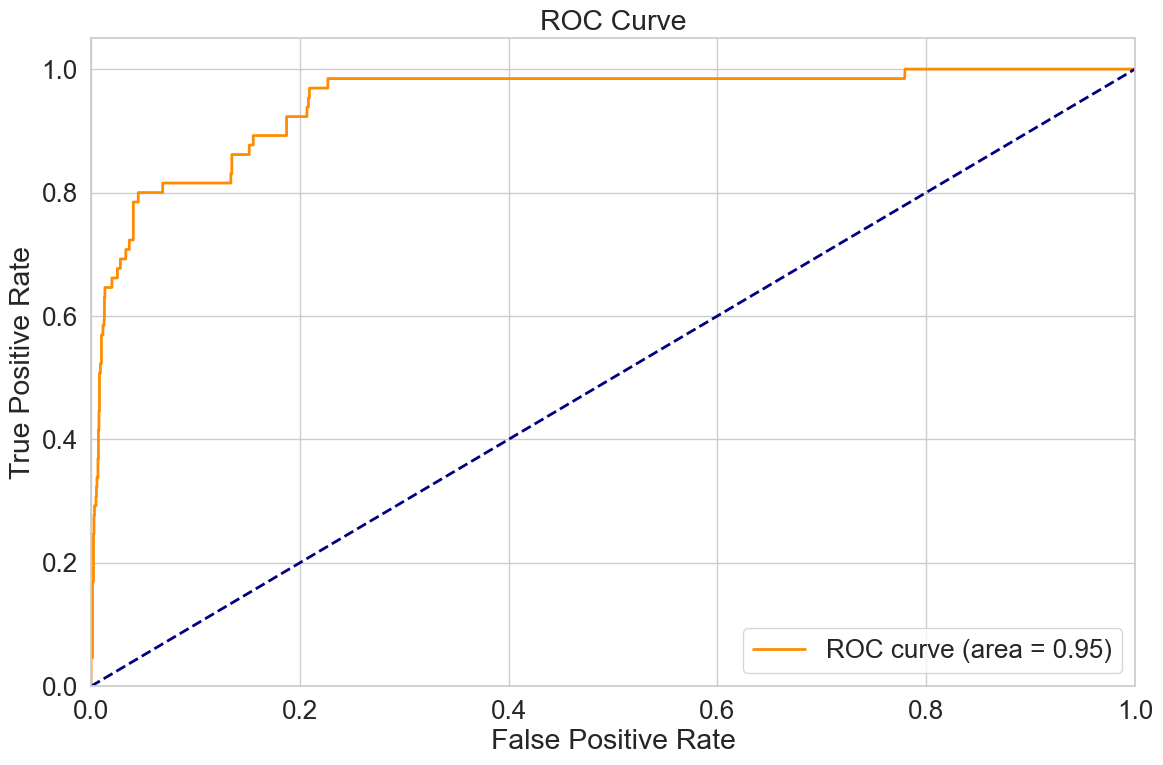

In [227]:
y_scores = model.predict_proba(X_test)[:, 1]

#Вычислите ROC-кривую и AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

#Постройте ROC-кривую
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Submisstion

In [ ]:
import pandas as pd
submisstion = pd.DataFrame()
submisstion['client_id'] = df['client_id']
submisstion['Probability'] = model.predict(test)